<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/handwriting-recognition-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Recognition - Pytorch

This notebook contains code to create a deep learning handwriting recognition
model in Pytorch. The model is for offline handwritten text using
line-level segmentations. It is an implementation of the paper,
*Gated Convolutional Recurrent Neural Network for Handwriting Recognition* as
recorded in [Bluche](http://ieeexplore.ieee.org/document/8270042/). BYU access
can be found [here](https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042).

### Imports

In [0]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

# Make sure we are using a GPU on Colab
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Data Structures
import numpy as np
import pandas as pd
import cv2
import csv
import json

# Python
import os
import time
import tarfile
import gzip
import gc

# Image/Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
from tqdm import tqdm

# Colab (We can use this if we want to import files from Google Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Debugging
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

### Download the Dataset

We will be using a very common handwriting dataset called [IAM](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database).

Download and unzip the dataset from the BYU-Handwriting-Lab Google Drive (courtesy of a clever wget command described [here](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)). In many
instances, we would probably make use of the google.drive API that allows
us to mount our Google drive here in Colab; however, we use this method
because it doesn't require us to authenticate.

A char_set.json file is also downloaded which contains a mapping between
characters and indices.

In [0]:
# ID = 1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn
# FILENAME = iam-line-level.zip
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn" -O iam-line-level.zip && rm -rf /tmp/cookies.txt
!unzip -q iam-line-level.zip -d iam
!rm iam-line-level.zip
!wget -q https://raw.githubusercontent.com/BYU-Handwriting-Lab/GettingStarted/master/data/char_set.json

Make sure we have the *char_set.json* file and *iam/* directory.

In [3]:
!ls

char_set.json  iam  sample_data


### Encoder/Decoder Class

This class allows us to map between string labels and actual index tensors that
represent a string.

In [0]:
class Encoder():
  def __init__(self, sequence_size=128):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs

  def idxs_to_str(self, idxs, remove_duplicates=True):
    string = ''

    if remove_duplicates:
      idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []

    for string in batch:
      idx = self.str_to_idxs(string)
      idxs.append(idx)

    return idxs
  
  def idxs_to_str_batch(self, batch, remove_duplicates=True):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs, remove_duplicates=remove_duplicates))
    
    return strings

### Helper Functions

A quick helper function that will display a few images for us when we display
our results.

In [0]:
def show_imgs(x, new_fig=True, figsize=(16,16)):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure(figsize=figsize)
    plt.imshow(grid.numpy())

def word_lengths_tensor(words):
  lengths = []

  if type(words) == str:
    length = len(word)
    if length > 16:
      length = 16
    lengths.append(length)
    return torch.tensor(lengths)
  else:
    for word in words:
      length = len(word)
      if length > 16:
        length = 16
      lengths.append(length)
    return torch.tensor(lengths)

### Dataset

To create a dataset in Pytorch, we extend the *Dataset* class and implement the
*\_\_getitem\_\_* and *\_\_len\_\_* methods. We also use a couple other
methods to resize the image and transform it to a tensor.

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(64, 1024), total_imgs=None):
    self.img_path = '/content/iam/images/'
    labels_path = '/content/iam/labels.csv'

    if not os.path.exists(labels_path) or not os.path.exists(self.img_path):
      raise Exception('Iam dataset does not exist in ' + labels_path)

    self.desired_size = desired_size
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = df[:total_imgs]

    self.encoder = Encoder(sequence_size=128)

  def resize(self, img, desired_size):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = desired_size[0]
      new_width = int(desired_size[0] // img_ratio)
    else:
      # Solve by width
      new_height = int(desired_size[1] * img_ratio)
      new_width = desired_size[1]

    img = np.array(img.resize((new_width, new_height)))

    border_top = desired_size[0] - new_height
    border_right = desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img, self.desired_size)
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    img = self.tensor_image(self.img_path + self.df['word'][index])

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

Check to make sure our dataset is giving us what we expect

Tensor Shape: torch.Size([1, 64, 1024])
Label: A MOVE to stop Mr. Gaitskell from


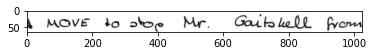

In [7]:
dataset = IamDataset()
img, label = dataset[0]

print('Tensor Shape:', img.shape)
print('Label:', label)
imshow(img.squeeze(), cmap='gray')

### Handwriting Recognition Model

We follow the architecture given by [Bluche](http://ieeexplore.ieee.org/document/8270042/).



In [8]:
torch.tensor([[[1, 1], [1, 1]], [[1, 1], [1, 1]]]) * torch.tensor([[[.5, .3], [.2, .1]], [[.5, .3], [.2, .1]]])

tensor([[[0.5000, 0.3000],
         [0.2000, 0.1000]],

        [[0.5000, 0.3000],
         [0.2000, 0.1000]]])

In [0]:
class GatedConv2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, **kwargs):
    super(GatedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, **kwargs)
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.gated_conv = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, activation=F.tanh):
    out = super(GatedConv2d, self).forward(x)
    out = activation(out)
    gated_out = self.gated_conv(out)
    gated_out = self.sigmoid(out)

    return out * gated_out

In [0]:
class Recognizer(nn.Module):
  def __init__(self, vocabulary_size=197, vertical_dim=64):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 10

    # Encoder
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 2, 1), nn.Tanh())
    self.conv2 = nn.Sequential(GatedConv2d(8, 16, 3, 1, 1))
    self.conv3 = nn.Sequential(GatedConv2d(16, 32, 3, 2, 1))
    self.conv4 = nn.Sequential(GatedConv2d(32, 64, 3, 1, 1))
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.Tanh())

    # Maxpool
    self.mp = nn.MaxPool2d((vertical_dim // 8, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Sequential(nn.Linear(self.hidden_size * 2, 128), nn.Tanh())
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, 197)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.squeeze(2)

    # Permute so that our second parameter contains sequential information (width)
    out = out.permute(0, 2, 1) 

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

Make sure our model works with one image from the dataset.

Create our needed dataset, model, and encoder objects, and reshape the image
tensor as necessary.

In [94]:
dataset = IamDataset()
model = Recognizer()
encoder = Encoder(sequence_size=128)
img, label = dataset[0]
img = img.unsqueeze(0) # Expand the dimension at 0 because our model expects data to be given in batches
img.shape

torch.Size([1, 1, 64, 1024])

Send one image from the dataset through the model.

In [86]:
preds = model(img).permute(1, 0, 2)
preds.shape

torch.Size([1, 197, 128])

Decode the output of the model. The model isn't trained so our prediction
will be garbage.

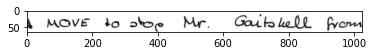

Prediction: ['ié"oï¬ ïîïïÉï ï´ïX Këïéï! ïïë´·ïîïïéïæïèïêï"îï¾´ïéëîïîïìïMï¾élïçïìïï3ïï!%ïènïÉïï$ëéïÀ$êëïº? pïTîïïîïêìïìïZëïïï#ï"!']
Target: A MOVE to stop Mr. Gaitskell from


In [80]:
label_prediction = encoder.idxs_to_str_batch(preds.argmax(dim=2))

imshow(img.squeeze(), cmap='gray')
plt.pause(.1)

print('Prediction:', label_prediction)
print('Target:', label)

### Training

Train the handwriting recognition model. Here we train for 200 epochs, with a
batch size of 100. Handwriting recognition models are trained using CTC-Loss
which works well with sequential information.

In [0]:
def train():
  try:
    EPOCHS = 100
    BATCH_SIZE = 64

    dataset = IamDataset(desired_size=(64, 1024))
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)) + 1, int(.2 * len(dataset))])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    recognizer = Recognizer().cuda()
    encoder = Encoder(sequence_size=128)
    optimizer = optim.Adam(recognizer.parameters(), lr=1e-3)
    objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
      # Train Loop
      loop = tqdm(total=len(train_loader), position=0, leave=True)
      train_loss_single = []
      for batch_num, (imgs, words) in enumerate(train_loader):
        batch_size = imgs.shape[0]
        imgs, labels = imgs.cuda(), torch.tensor(encoder.str_to_idxs_batch(words)).cuda()

        word_labels = labels.squeeze().long()
        input_lengths = torch.full((batch_size,), 128, dtype=torch.long) # (BATCH_SIZE) -> Sequence_Length
        target_lengths = word_lengths_tensor(words)

        preds = recognizer(imgs)

        loss = objective(preds, word_labels, input_lengths, target_lengths)
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_single.append(loss.item())
        loop.set_description('Train      - Epoch: {}, Loss: {:.4f}, AvgEpochLoss: {:.4f}'.format(epoch, loss.item(), np.mean(train_loss_single)))
        loop.update(1)

      train_losses.append(np.mean(train_loss_single))
      loop.close()

      gc.collect()

      val_loss_single = []
      # Validation Loop
      val_loop = tqdm(total=len(val_loader), position=0, leave=True)
      for val_batch_num, (val_imgs, val_words) in enumerate(val_loader):
        val_batch_size = val_imgs.shape[0]
        val_imgs, val_labels = val_imgs.cuda(), torch.tensor(encoder.str_to_idxs_batch(val_words)).cuda()

        val_word_labels = val_labels.squeeze().long()
        val_input_lengths = torch.full((val_batch_size,), 128, dtype=torch.long)
        val_target_lengths = word_lengths_tensor(val_words)

        val_preds = recognizer(val_imgs)

        val_loss = objective(val_preds, val_word_labels, val_input_lengths, val_target_lengths)
        val_loss = torch.mean(val_loss)

        val_loss_single.append(val_loss.item())
        val_loop.set_description('Validation - Epoch: {}, Loss: {:.4f}, AvgEpochLoss: {:.4f}'.format(epoch, val_loss.item(), np.mean(val_loss_single)))
        val_loop.update(1)

      val_losses.append(np.mean(val_loss_single))
      val_loop.close()
    
  except:
    __ITB__()
    gc.collect()
  finally:
    return recognizer, train_losses, val_losses

In [0]:
recognizer, train_losses, val_losses = train()

Save the weights to our model if desired.

In [0]:
torch.save(recognizer.state_dict(), 'recognizer.model')

### Results

Display the loss curve of the model over time.

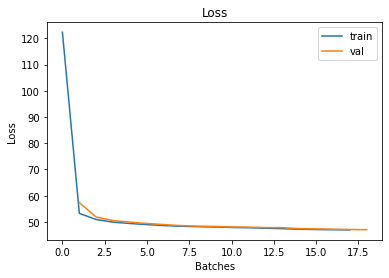

In [70]:
# Plot the Loss
tl_len = len(train_losses)
vl_len = len(val_losses)
y, x = val_losses, range(tl_len // vl_len, tl_len + 1, tl_len // vl_len)
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
plt.plot(x, y, label='val')
plt.legend()
plt.show()